#### Notes<br>
<br>
In order to change the parameter `a` that controls how the sampler moves during its walk, you need to update the `emcee` package to the most recent version. To do this, run `pip install --upgrade emcee`.<br>
<br>
Note that older notebooks will not work with this newer version, but any code that uses `fit2d` to run the MCMC will handle the version change. If you really need to run an older notebook (though it should be easy to port those parameters to a notebook based off this one) you can downgrade the version using `pip install emcee==2.2.1`.<br>
<br>
This notebook, and any other code using `fit2d`, can run on the older version of emcee but you won't be able to change the move parameter.

Rotating disk - 40 km/s<br>
w/ structural params<br>
1 bin for the entire galaxy<br>
using fill nan

making a 1-1 comparison b/w this and the mathematica notebook results (chisq-analytical7)

Same as the sini fit w/ a cropped field, but fitting inc instead -- fixed vel AND pa

In[1]:

In [1]:
from fit2d import Galaxy, RingModel
from fit2d.mcmc import LinearPrior
from fit2d.mcmc import emcee_lnlike, piecewise_start_points
from fit2d.models import PiecewiseModel

from astropy.io import fits
import copy
from datetime import datetime
import glob
import joblib
import numpy as np
import os

import emcee
from emcee import EnsembleSampler, moves

In[2]:

number of bins in fit

In [2]:
num_bins = 10
# min and max bounds for each bin
vmin, vmax = 0, 200

# min and max inc, pos angle in RADIANS
inc_min, inc_max = np.radians(0), np.radians(85)
pos_angle_min, pos_angle_max = np.radians(0), np.radians(360)

name = "NGC2366"
distance = 3400. # [kpc]

home_directory = "/Users/stephencoffey/Downloads/little-things/data"
observed_2d_vel_field_fits_file = f"{home_directory}/NGC2366_1mom_cropped.fits"
# to use the dispersion as a source of errors, provide this file name
# observed_2d_dispersion_fits_file = f"{home_directory}/NGC2366_2mom.fits"
deg_per_pixel=4.17e-4

ring_param_file = f"{home_directory}/NGC2366_ring_parameters_rohit.txt"
v_systemic = 100 #changed to 100 to equal exactly what we used in mathematica

In [3]:
# x and y dims are switched in ds9 fits display versus np array shape
fits_ydim, fits_xdim = fits.open(observed_2d_vel_field_fits_file)[0].data.shape

mask_sigma=1.
random_seed = 1234

mcmc_nwalkers = 30
mcmc_niter = 500
mcmc_ndim = 12  # Do not change this if fitting one ring at a time
mcmc_nthreads = 40
# Try increasing stretch scale factor a. version must be >=3 for this to be used.
mcmc_moves = moves.StretchMove(a = 2)
mcmc_version = float(emcee.__version__[0])

# Option to save every batch_size iterations in case of crash<br>
# Increase this; 2 is a very low value just for testing

batch_size = 25

# option to save outputs in a particular directory
save_dir = "/Users/stephencoffey/Downloads/little-things/notebooks/experiments/fake_gal/debugging/real_data/10rings/"

### This is where you can provide a 2D array of pixel errors.<br>
### Only one of these should be set- SET THE OTHER TO HAVE value `None`<br>
<br>
#### Note the order the parameters are specified in the `ring_param_bounds`:  index 1 corresponds to the inclination, index 2 corresponds to position angle.

In[3]:

In [4]:
galaxy = Galaxy(
    name=name,
    distance=distance,
    observed_2d_vel_field_fits_file=observed_2d_vel_field_fits_file,
    deg_per_pixel=deg_per_pixel,
    v_systemic=v_systemic
)

In [5]:
ring_model = RingModel(
    ring_param_file=ring_param_file,
    fits_xdim=fits_xdim,
    fits_ydim=fits_ydim,
    distance=distance
)

ring_param_bounds = [(vmin, vmax), (vmin, vmax), (vmin, vmax), (vmin, vmax), (vmin, vmax), (vmin, vmax), (vmin, vmax), (vmin, vmax), (vmin, vmax), (vmin, vmax), (inc_min, inc_max), (pos_angle_min, pos_angle_max)]



mapping of ring struct params to their index in the parameters (same as specified in bounds)<br>
this is provided as an optional argument to lnlike to tell it which parameters to use as inc and pos_angle

In [6]:
fit_structural_params = {"inc": 10, "pos_angle": 11}

In [7]:
vels, incs, pos_angles = np.loadtxt(ring_param_file, usecols=(2, 4, 5)).T
v_rot = []
bin_indices = np.linspace(0, len(ring_model.radii_kpc_interp)-1, num_bins + 1)
bin_edges = []
for i in bin_indices:
    bin_edges.append(ring_model.radii_kpc_interp[int(i)])
for i in range(len(bin_indices)-1):
    v_rot.append(np.mean(vels[int(bin_indices[i]):int(bin_indices[i+1])]))

/Users/stephencoffey/anaconda2/envs/anna_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/stephencoffey/anaconda2/envs/anna_env/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In[4]:

One, but not both, should be provided to lnlike

In [8]:
print(v_rot)

[12.612, 31.484, 44.101800000000004, 52.24366666666666, 53.532000000000004, 53.377, nan, nan, nan, nan]


In [9]:
v_err_const = 10. # [km/s] constant error per pixel
v_err_2d = None

to use the 2nd moment map,<br>
v_err_const = None<br>
v_err_2d = galaxy.observed_2d_dispersion

The code below has been altered to change the "observations" to a fake array<br>
with a constant circular velocity at all radii.<br>
<br>
Set the variable `v_rot_fake` to the constant velocity<br>


In[ ]:

In [10]:
import warnings
warnings.simplefilter('ignore')
from joblib import Parallel, delayed
from fit2d._velocity_field_generator import create_2d_velocity_field

inc = np.radians(60)  # fill this in with something within the priors
pos_angle = np.radians(40) # fill this in with something within the priors

# if inc and/or pos_angle are not being fit in the MCMC, they will be fixed to constant values inc_fake, pos_angle_fake

ring_model.update_structural_parameters(inc=inc, pos_angle=pos_angle)

In [11]:
from fit2d.mcmc._likelihood import chisq_2d, lnlike
import matplotlib.pyplot as plt
#from mpl_toolkits import mplot3d
#%matplotlib notebook

"""fake_observed_2d_vel_field = create_2d_velocity_field(
        radii = [bin_edges[0], bin_edges[-1]],
        v_rot = [40, 40],  # just fill in any velocity
        i = inc_fake,
        pa = pos_angle_fake,
        v_sys = galaxy.v_systemic,
        x_dim = galaxy.image_xdim,
        y_dim = galaxy.image_ydim,
        x_center = fits_xdim/2,
        y_center = fits_ydim/2,
        kpc_per_pixel = galaxy.kpc_per_pixel
        )
plt.imshow(fake_observed_2d_vel_field)
plt.colorbar()
plt.title("fake data")
plt.show()"""


bin_min, bin_max = bin_edges[0], bin_edges[-1]

galaxy.observed_2d_vel_field = fits.open(observed_2d_vel_field_fits_file)[0].data
dimensions = galaxy.observed_2d_vel_field.shape

piecewise_model = PiecewiseModel(num_bins=num_bins)
piecewise_model.set_bounds(array_bounds=ring_param_bounds)
piecewise_model.set_bin_edges(rmin=bin_min, rmax=bin_max)
radii_to_interpolate = np.array([r for r in ring_model.radii_kpc_interp if bin_min<=r<=bin_max])
prior = LinearPrior(bounds=piecewise_model.bounds)
prior_transform = prior.transform_from_unit_cube

# instead of using piecewise_model.bounds, we've manually input bounds for the starting positions so the walkers start out much closer to the value we're looking for
start_positions = piecewise_start_points(mcmc_nwalkers, bounds = [(9,11), (16,18), (20, 22), (29,31), (39, 41), (44, 46), (49, 51), (51, 53), (53, 55), (53, 55), (inc - 0.1, inc + 0.1), (pos_angle - 0.1, pos_angle + 0.1)], random_seed=random_seed)
fit_inputs = {
    "piecewise_model": piecewise_model,
    "galaxy": galaxy,
    "ring_model": ring_model,
    "prior_transform": prior_transform
}
#print(f"Fitting ring {bin_index}")
rotation_curve_func_kwargs = {
    "radii_to_interpolate": radii_to_interpolate}
lnlike_args = {
    "model": piecewise_model,
    "rotation_curve_func_kwargs": rotation_curve_func_kwargs,
    "galaxy": galaxy,
    "ring_model": ring_model,
    "mask_sigma": mask_sigma,
    "v_err_const": v_err_const,
    "v_err_2d": v_err_2d,
    "fit_structural_params": fit_structural_params
}

"""fig = plt.figure()
ax = plt.axes(projection = '3d')
inc = np.linspace(0.1, np.pi/2 - 0.1, 10)
pa = np.linspace(0.1, 2*np.pi - 0.1, 10)
lnlikes = np.empty((len(inc), len(pa)))
for y in range(len(pa)):
    for x in range(len(inc)):
        lnlikes[x,y] = lnlike([v_rot[bin_index], inc[x], pa[y]], **lnlike_args) 
ax.plot_surface(inc, pa, lnlikes)

print(lnlikes)"""
sampler = EnsembleSampler(
    mcmc_nwalkers,
    mcmc_ndim,
    emcee_lnlike,
    args=[mcmc_version, lnlike_args],
    threads=mcmc_nthreads,
)
if mcmc_version >= 3:
    sampler._moves = [mcmc_moves]
sampler_output_file = os.path.join(
    save_dir or "", f"sampler_{galaxy.name}.pkl")

In [12]:
for batch in range(mcmc_niter // batch_size):
    if batch == 0:
        batch_start = start_positions
    else:
        batch_start = None
        sampler.pool = temp_pool
    sampler.run_mcmc(batch_start, batch_size)
    temp_pool = sampler.pool
    del sampler.pool
    with open(sampler_output_file, 'wb') as f:
        sampler_copy = copy.copy(sampler)
        del sampler_copy.log_prob_fn
        joblib.dump(sampler_copy, f)

    print(f"Done with steps {batch*batch_size} - {(batch+1)*batch_size} out of {mcmc_niter}")

Done with steps 0 - 25 out of 500
Done with steps 25 - 50 out of 500
Done with steps 50 - 75 out of 500
Done with steps 75 - 100 out of 500
Done with steps 100 - 125 out of 500
Done with steps 125 - 150 out of 500
Done with steps 150 - 175 out of 500
Done with steps 175 - 200 out of 500
Done with steps 200 - 225 out of 500
Done with steps 225 - 250 out of 500
Done with steps 250 - 275 out of 500
Done with steps 275 - 300 out of 500
Done with steps 300 - 325 out of 500
Done with steps 325 - 350 out of 500
Done with steps 350 - 375 out of 500
Done with steps 375 - 400 out of 500
Done with steps 400 - 425 out of 500
Done with steps 425 - 450 out of 500
Done with steps 450 - 475 out of 500
Done with steps 475 - 500 out of 500


In [13]:
print(f"Done with emcee fit for {galaxy.name}")

Done with emcee fit for NGC2366


In [14]:
"""log_probs = sampler.get_log_prob()
print("log prob of best fit point:", np.amax(log_probs))
log_max = np.where(log_probs == np.amax(log_probs))
param_vals = sampler.get_chain()[log_max]
print("vel, inc, vsini of best fit point:", (param_vals[0][0], param_vals[0][1],param_vals[0][0]*np.sin(param_vals[0][1]) ))
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))
#print("Mean autocorrelation time: {0:.3f} steps".format(np.mean(sampler.get_autocorr_time())))"""

'log_probs = sampler.get_log_prob()\nprint("log prob of best fit point:", np.amax(log_probs))\nlog_max = np.where(log_probs == np.amax(log_probs))\nparam_vals = sampler.get_chain()[log_max]\nprint("vel, inc, vsini of best fit point:", (param_vals[0][0], param_vals[0][1],param_vals[0][0]*np.sin(param_vals[0][1]) ))\nprint("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))\n#print("Mean autocorrelation time: {0:.3f} steps".format(np.mean(sampler.get_autocorr_time())))'

In [15]:
from fit2d._velocity_field_generator import create_2d_velocity_field

from astropy.io import fits
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

'fake_data = create_2d_velocity_field(\n    radii = [bin_edges[0], bin_edges[-3]],\n    v_rot = [40,40],  # just fill in any velocity\n        i=inc_fake,\n        pa=pos_angle_fake,\n        v_sys = 100,\n        x_dim = galaxy.image_xdim,\n        y_dim = galaxy.image_ydim,\n        x_center = fits_xdim/2,\n        y_center = fits_ydim/2, \n        kpc_per_pixel=0.024745278134775603\n)'

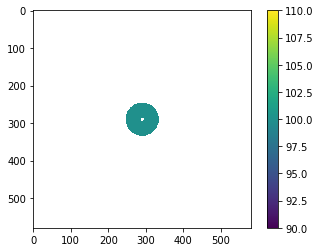

In [16]:
model = create_2d_velocity_field(
    radii = [bin_edges[0], bin_edges[1]],
    v_rot = [v_rot[0], v_rot[0]],  # just fill in any velocity
        i= np.radians(0),
        pa= pos_angle,
        v_sys = 100,
        x_dim = galaxy.image_xdim,
        y_dim = galaxy.image_ydim,
        x_center = fits_xdim/2,
        y_center = fits_ydim/2, 
        kpc_per_pixel=0.024745278134775603
)

plt.imshow(model)
plt.colorbar()
"""fake_data = create_2d_velocity_field(
    radii = [bin_edges[0], bin_edges[-3]],
    v_rot = [40,40],  # just fill in any velocity
        i=inc_fake,
        pa=pos_angle_fake,
        v_sys = 100,
        x_dim = galaxy.image_xdim,
        y_dim = galaxy.image_ydim,
        x_center = fits_xdim/2,
        y_center = fits_ydim/2, 
        kpc_per_pixel=0.024745278134775603
)"""

NameError: name 'fake_data' is not defined

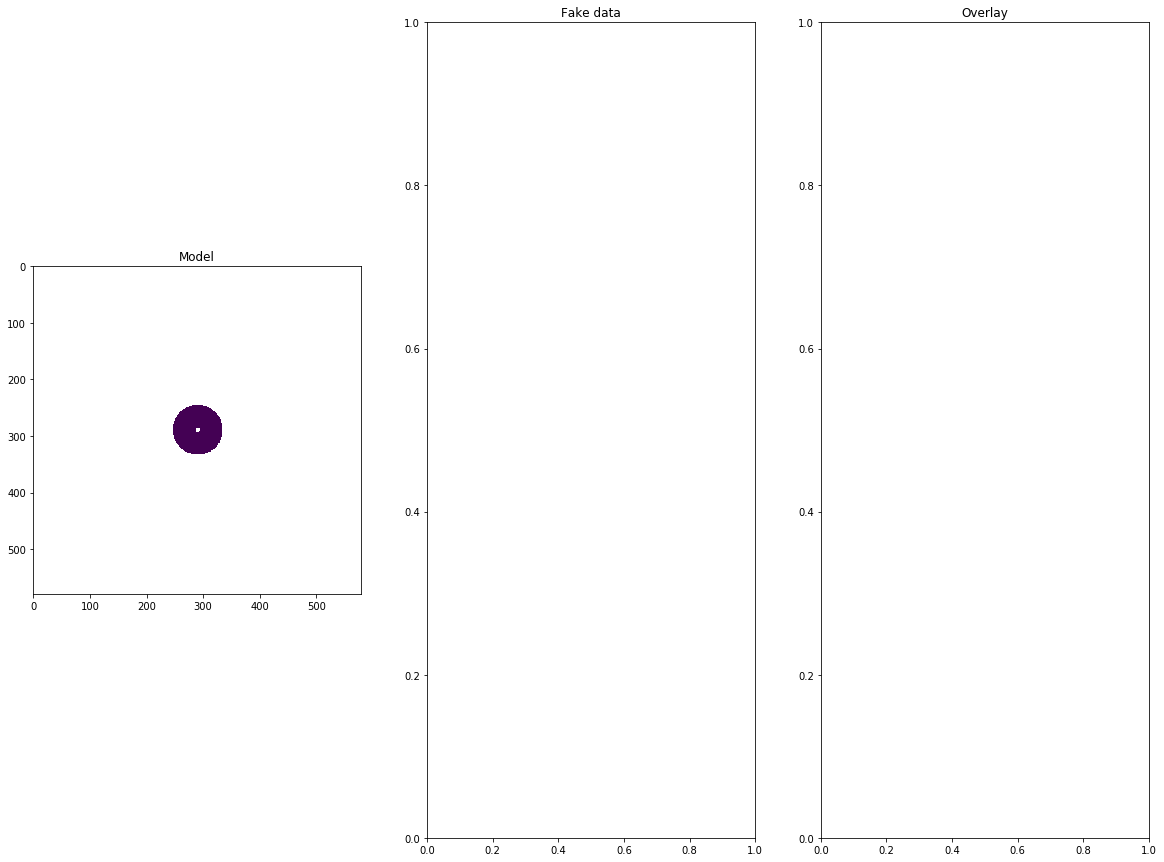

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20,15))
ax1.set_title("Model")
ax2.set_title("Fake data")
ax3.set_title("Overlay")
im1 = ax1.imshow(model)
im2 = ax2.imshow(fake_data)
ax3.imshow(model, alpha = 0.75, cmap = 'Reds')
ax3.imshow(fake_data, alpha = 0.5, cmap = 'Blues')

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.1)
fig.colorbar(im1, cax=cax, orientation='vertical')

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.1)
fig.colorbar(im2, cax=cax, orientation='vertical')

In [ ]:
plt.imshow(model - fake_data)
plt.title("Model - fake data")
plt.colorbar()
plt.show()

In [ ]:
from mpl_toolkits import mplot3d
%matplotlib notebook

log_probs = sampler.get_log_prob()
chain = sampler.get_chain()

fig = plt.figure()
ax = plt.axes(projection = '3d')
for i in range(mcmc_nwalkers):
    vrot = chain[:,i,0]
    incs = chain[:,i,1]
    ax.plot3D(vrot, incs, log_probs[:,i])
    ax.set_xlabel('vrots')
    ax.set_ylabel('incs')
    ax.set_zlabel('log probs')
    

#print("log prob of first point:", log_probs[0][0])
#print("param vals of first point:", chain[0])

#print("log prob of best fit point:", np.amax(log_probs))
log_max = np.where(log_probs == np.amax(log_probs))
param_vals = chain[log_max] # indexing is [iteration,walker,param]
#print("List of indices of best fit point:",log_min[0])
#print("sin(inc) of best fit point:", (param_vals[0][1])) 

### 